In [46]:
import sys
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import glob
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE

In [47]:
config = {
    "train_batchsz" : 64,
    "epoch" : 70,
    "lr" : 1.0e-3,
    "betas" : (0., 0.999),
    "mnistm_path" : "/data/dlcv/hw2/hw2_data/digits/mnistm/",
    "svhn_path" : "/data/dlcv/hw2/hw2_data/digits/svhn/",
    "device" :  "cuda" if torch.cuda.is_available() else "cpu",
    "numofclass" : 10,
    "lamb" : 0.2,
}
source_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])
target_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
])
if config["device"] == "cuda":
    torch.cuda.set_device(2)
print('Device used :', config["device"])

Device used : cuda


In [48]:
class SVHN_FeatureExtractor(nn.Module):
    def __init__(self, channel=3):
        super(SVHN_FeatureExtractor, self).__init__()
        self.conv1 = self.block(dim_in=channel, dim_out=64) #(bsz, 64, 14, 14)
        self.conv2 = self.block(dim_in=64, dim_out=128) #(bsz, 128, 7, 7)
        self.conv3 = self.block(dim_in=128, dim_out=256, pad=0, maxpool=False) #(bsz, 256, 5, 5)
        self.conv4 = self.block(dim_in=256, dim_out=256, pad=0, maxpool=False) #(bsz, 256, 3, 3)
        self.conv5 = self.block(dim_in=256, dim_out=512, pad=0, maxpool=False) #(bsz, 512, 1, 1)
    def block(self, dim_in, dim_out, ksz=3, stride_=1, pad=1, maxpool=True):
        if maxpool:
            return nn.Sequential(
                nn.Conv2d(dim_in, dim_out, kernel_size=3, stride=1, padding=pad),
                nn.BatchNorm2d(dim_out),
                nn.ReLU(True),
                nn.MaxPool2d(2)
            )
        return nn.Sequential(
                nn.Conv2d(dim_in, dim_out, kernel_size=3, stride=1, padding=pad),
                nn.BatchNorm2d(dim_out),
                nn.ReLU(True)
            )    
    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x5 = self.conv5(x4)
        return x5.flatten(1)

In [49]:
class SVHN_LabelPredictor(nn.Module):
    def __init__(self):
        super(SVHN_LabelPredictor, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, config["numofclass"])
        )
    def forward(self, h):
        c = self.layer(h)
        return c

In [50]:
class SVHN_DomainClassifier(nn.Module):
    def __init__(self):
        super(SVHN_DomainClassifier, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 1),
        )
    def forward(self, h):
        y = self.layer(h)
        return y

In [51]:
class DigitDataset(Dataset):
    def __init__(self, datapath, csvpath=None, transform=None) -> None:
        self.data = []
        if os.path.exists(datapath):
            if csvpath is None:
                filenames = glob.glob(os.path.join(datapath, "*.png"))
                for filename in filenames:
                    self.data.append((filename, ))
            elif os.path.exists(csvpath):
                df = pd.read_csv(csvpath)
                self.data = [(os.path.join(datapath, name), label) for name, label in zip(df["image_name"], df["label"])]
            else:
                print("Can't find {}".format(csvpath))
                exit(-1)
        else:
            print("Can't find {}".format(datapath))
            exit(-1)
        self.len = len(self.data)
        self.transform = transform

    def __getitem__(self, index):
        img_fn, label = self.data[index]
        img = Image.open(img_fn)
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return self.len

In [52]:
def imshow(img):
    # img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {'model_state_dict': model.state_dict(),
             'optimizer_state_dict' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to {}'.format(checkpoint_path))
def load_checkpoint(checkpoint_path, device='cpu'):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    return checkpoint["model_state_dict"], checkpoint["optimizer_state_dict"]

In [53]:
class DANN_SVHM():
    def __init__(self) -> None:
        self.F = SVHN_FeatureExtractor().to(config["device"])
        self.C = SVHN_LabelPredictor().to(config["device"])
        self.D = SVHN_DomainClassifier().to(config["device"])

        self.class_criterion = nn.CrossEntropyLoss()
        self.domain_criterion = nn.BCEWithLogitsLoss()

        self.optimizer_F = optim.Adam(self.F.parameters())
        self.optimizer_C = optim.Adam(self.C.parameters())
        self.optimizer_D = optim.Adam(self.D.parameters())

    def CreateLoader(self):
        self.mnistm_train_loader = DataLoader(DigitDataset(datapath=os.path.join(config["mnistm_path"], "data"), csvpath=os.path.join(config["mnistm_path"], "train.csv"), transform=source_transform), 
                                            batch_size=config["train_batchsz"], shuffle=True)
        self.mnistm_val_loader = DataLoader(DigitDataset(datapath=os.path.join(config["mnistm_path"], "data"), csvpath=os.path.join(config["mnistm_path"], "val.csv"), transform=val_transform),
                                            batch_size=config["train_batchsz"], shuffle=False)
        self.svhn_train_loader = DataLoader(DigitDataset(datapath=os.path.join(config["svhn_path"], "data"), csvpath=os.path.join(config["svhn_path"], "train.csv"), transform=target_transform), 
                                            batch_size=config["train_batchsz"], shuffle=True)
        self.svhn_val_loader = DataLoader(DigitDataset(datapath=os.path.join(config["svhn_path"], "data"), csvpath=os.path.join(config["svhn_path"], "val.csv"), transform=val_transform),
                                            batch_size=config["train_batchsz"], shuffle=False)
        # imshow(torchvision.utils.make_grid(next(iter(self.mnistm_train_loader))[0], padding=0))
        # imshow(torchvision.utils.make_grid(next(iter(self.svhn_train_loader))[0], padding=0))
        print(len(self.mnistm_train_loader.dataset), len(self.mnistm_val_loader.dataset), len(self.svhn_train_loader.dataset), len(self.svhn_val_loader.dataset))
    
    def train(self):
        self.CreateLoader()
        lamb = config["lamb"]
        best_acc = 0.
        for ep in range(config["epoch"]):
            self.F.train()
            self.C.train()
            self.D.train()
            F_loss, C_loss, D_loss = 0., 0., 0.
            mnistm_acc, svhn_acc = 0, 0
            for idx, ((mnistm_img, mnistm_label), (svhn_img, svhn_label)) in enumerate(zip(self.mnistm_train_loader, self.svhn_train_loader)):
                mnistm_img, svhn_img = mnistm_img.to(config["device"]), svhn_img.to(config["device"])
                #train domain classifier
                mixed_data = torch.cat([mnistm_img, svhn_img], dim=0)
                domain_label = torch.zeros((mnistm_img.shape[0] + svhn_img.shape[0], 1), device=config["device"])
                domain_label[:mnistm_img.shape[0]] = 1
                feature = self.F(mixed_data)
                domain_logits = self.D(feature.detach())
                loss = self.domain_criterion(domain_logits, domain_label)
                D_loss += loss.item()
                self.D.zero_grad()
                loss.backward()
                self.optimizer_D.step()
                #train feature extrator & label predictor
                class_logit = self.C(feature[:mnistm_img.shape[0]]).cpu()
                mnistm_acc += (class_logit.argmax(1) == mnistm_label).sum().item()
                domain_logits = self.D(feature)
                loss = self.class_criterion(class_logit, mnistm_label) - lamb * self.domain_criterion(domain_logits, domain_label)
                F_loss += loss.item()
                self.C.zero_grad()
                self.F.zero_grad()
                loss.backward()
                self.optimizer_F.step()
                self.optimizer_C.step()
            with torch.no_grad():
                self.F.eval()
                self.C.eval()
                for idx, (svhn_img, svhn_label) in enumerate(self.svhn_val_loader):
                    feature = self.F(svhn_img.to(config["device"]))
                    y = self.C(feature).cpu()
                    svhn_acc += (y.argmax(1) == svhn_label).sum().item()
            if svhn_acc > best_acc :
                save_checkpoint("/data/allen/hw2model/mnistm_svhn_F.pth", self.F, self.optimizer_F)
                save_checkpoint("/data/allen/hw2model/mnistm_svhn_C.pth", self.C, self.optimizer_C)
                save_checkpoint("/data/allen/hw2model/mnistm_svhn_D.pth", self.D, self.optimizer_D)
                best_acc = svhn_acc
            print("Epoch[{}/{}] D_loss : {:.6f} F_loss : {:.6f} mnistm_acc : {:.2%} svhn_acc : {:.2%}".format(ep + 1, config["epoch"], D_loss / idx, F_loss / idx, 
                            mnistm_acc / min(len(self.mnistm_train_loader.dataset), len(self.svhn_train_loader.dataset)), svhn_acc / len(self.svhn_val_loader.dataset)))
    
    def lower_bound(self):
        self.CreateLoader()
        epochs = 35
        for ep in range(epochs):
            self.F.train()
            self.C.train()
            F_loss, C_loss = 0., 0.
            mnistm_acc, svhn_acc = 0, 0
            for idx, (mnistm_img, mnistm_label) in enumerate(self.mnistm_train_loader):
                mnistm_img = mnistm_img.to(config["device"])
                #train feature extrator & label predictor
                feature = self.F(mnistm_img)
                class_logit = self.C(feature).cpu()
                mnistm_acc += (class_logit.argmax(1) == mnistm_label).sum().item()
                loss = self.class_criterion(class_logit, mnistm_label)
                F_loss += loss.item()
                self.C.zero_grad()
                self.F.zero_grad()
                loss.backward()
                self.optimizer_F.step()
                self.optimizer_C.step()
            with torch.no_grad():
                self.F.eval()
                self.C.eval()
                for idx, (svhn_img, svhn_label) in enumerate(self.svhn_val_loader):
                    feature = self.F(svhn_img.to(config["device"]))
                    y = self.C(feature).cpu()
                    svhn_acc += (y.argmax(1) == svhn_label).sum().item()
            print("Epoch[{}/{}] F_loss : {:.6f} mnistm_acc : {:.2%} svhn_acc : {:.2%}".format(ep + 1, epochs, F_loss / idx, 
                    mnistm_acc / len(self.mnistm_train_loader.dataset), svhn_acc / len(self.svhn_val_loader.dataset)))
    
    def upper_bound(self):
        self.CreateLoader()
        epochs = 35
        for ep in range(epochs):
            self.F.train()
            self.C.train()
            train_loss, val_loss = 0., 0.
            train_svhn_acc, val_svhn_acc = 0, 0
            for idx, (svhn_img, svhn_label) in enumerate(self.svhn_train_loader):
                svhn_img = svhn_img.to(config["device"])
                #train feature extrator & label predictor
                feature = self.F(svhn_img)
                class_logit = self.C(feature).cpu()
                train_svhn_acc += (class_logit.argmax(1) == svhn_label).sum().item()
                loss = self.class_criterion(class_logit, svhn_label)
                train_loss += loss.item()
                self.C.zero_grad()
                self.F.zero_grad()
                loss.backward()
                self.optimizer_F.step()
                self.optimizer_C.step()
            with torch.no_grad():
                self.F.eval()
                self.C.eval()
                for idx, (svhn_img, svhn_label) in enumerate(self.svhn_val_loader):
                    feature = self.F(svhn_img.to(config["device"]))
                    y = self.C(feature).cpu()
                    val_loss += self.class_criterion(y, svhn_label)
                    val_svhn_acc += (y.argmax(1) == svhn_label).sum().item()
            print("Epoch[{}/{}] train_loss : {:.6f} train_svhn_acc : {:.2%} val_loss : {:.6f} val_svhn_acc : {:.2%}".format(ep + 1, epochs, train_loss / idx, 
                    train_svhn_acc / len(self.svhn_train_loader.dataset), val_loss / idx, val_svhn_acc / len(self.svhn_val_loader.dataset)))
    def tsne(self):
        self.CreateLoader()
        F_model_checkpoint, __ = load_checkpoint("/data/allen/hw2model/hw2_3_mnistm_svhn_F.pth", device=config["device"])
        F = SVHN_FeatureExtractor().to(config["device"])
        F.load_state_dict(F_model_checkpoint)
        F.eval()
        colors = np.random.random((config["numofclass"], 3))
        tsne = TSNE(n_components=2, learning_rate='auto', init='random') 
        with torch.no_grad():
            F_outputs, labels, domains = [], [], []
            for (mnistm_img, mnistm_label) in self.mnistm_val_loader:
                mnistm_img = mnistm_img.to(config["device"])
                feature = F(mnistm_img)
                F_outputs.append(feature.cpu().numpy())
                labels.append(mnistm_label)
                domains.append(np.ones(mnistm_img.shape[0], dtype=np.int8))
            for (svhn_img, svhn_label) in self.svhn_val_loader:
                svhn_img = svhn_img.to(config["device"])
                feature = F(svhn_img)
                F_outputs.append(feature.cpu().numpy())
                labels.append(svhn_label)
                domains.append(np.zeros(svhn_img.shape[0], dtype=np.int8))
            F_outputs, labels, domains = np.concatenate(F_outputs, axis=0), np.concatenate(labels, axis=0), np.concatenate(domains, axis=0)
            F_tsne = tsne.fit_transform(F_outputs)
            fig1, fig2 = plt.figure(1), plt.figure(2)
            ax1, ax2 = fig1.add_subplot(111), fig2.add_subplot(111)
            ax1.set_title('By class'), ax2.set_title('By domain')
            ax1.scatter(F_tsne[:,0], F_tsne[:,1], s=2, color=[tuple(colors[i]) for i in labels], alpha=0.4)
            ax2.scatter(F_tsne[:,0], F_tsne[:,1], s=2, color=['r' if i == 1 else 'b' for i in domains], alpha=0.4)
            plt.show()

## Train

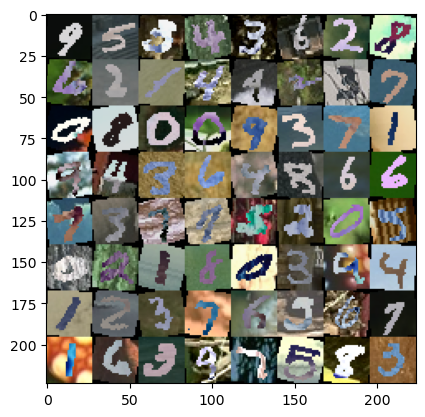

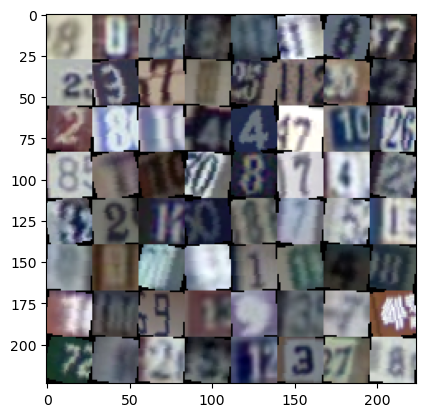

44800 11200 63544 15887
model saved to /data/allen/hw2model/mnistm_svhn_F.pth
model saved to /data/allen/hw2model/mnistm_svhn_C.pth
model saved to /data/allen/hw2model/mnistm_svhn_D.pth
Epoch[1/70] D_loss : 1.266818 F_loss : 0.886949 mnistm_acc : 87.29% svhn_acc : 38.45%
model saved to /data/allen/hw2model/mnistm_svhn_F.pth
model saved to /data/allen/hw2model/mnistm_svhn_C.pth
model saved to /data/allen/hw2model/mnistm_svhn_D.pth
Epoch[2/70] D_loss : 1.270113 F_loss : 0.277264 mnistm_acc : 94.32% svhn_acc : 45.58%
model saved to /data/allen/hw2model/mnistm_svhn_F.pth
model saved to /data/allen/hw2model/mnistm_svhn_C.pth
model saved to /data/allen/hw2model/mnistm_svhn_D.pth
Epoch[3/70] D_loss : 1.292028 F_loss : 0.169402 mnistm_acc : 95.40% svhn_acc : 46.43%
model saved to /data/allen/hw2model/mnistm_svhn_F.pth
model saved to /data/allen/hw2model/mnistm_svhn_C.pth
model saved to /data/allen/hw2model/mnistm_svhn_D.pth
Epoch[4/70] D_loss : 1.330583 F_loss : 0.093091 mnistm_acc : 96.16% sv

In [9]:
model = DANN_SVHM()
model.train()

## Lower bound

In [9]:
model = DANN_SVHM()
model.lower_bound()

44800 11200 63544 15887
Epoch[1/35] F_loss : 1.059866 mnistm_acc : 87.95% svhn_acc : 29.41%
Epoch[2/35] F_loss : 0.486296 mnistm_acc : 94.66% svhn_acc : 38.35%
Epoch[3/35] F_loss : 0.380219 mnistm_acc : 95.85% svhn_acc : 35.40%
Epoch[4/35] F_loss : 0.311746 mnistm_acc : 96.62% svhn_acc : 33.29%
Epoch[5/35] F_loss : 0.273123 mnistm_acc : 96.93% svhn_acc : 31.93%
Epoch[6/35] F_loss : 0.245675 mnistm_acc : 97.23% svhn_acc : 35.50%
Epoch[7/35] F_loss : 0.226474 mnistm_acc : 97.49% svhn_acc : 30.80%
Epoch[8/35] F_loss : 0.194696 mnistm_acc : 97.77% svhn_acc : 37.83%
Epoch[9/35] F_loss : 0.178434 mnistm_acc : 98.02% svhn_acc : 33.67%
Epoch[10/35] F_loss : 0.161107 mnistm_acc : 98.18% svhn_acc : 24.54%
Epoch[11/35] F_loss : 0.143319 mnistm_acc : 98.42% svhn_acc : 29.88%
Epoch[12/35] F_loss : 0.142630 mnistm_acc : 98.43% svhn_acc : 33.50%
Epoch[13/35] F_loss : 0.128356 mnistm_acc : 98.62% svhn_acc : 32.25%
Epoch[14/35] F_loss : 0.119440 mnistm_acc : 98.70% svhn_acc : 30.30%
Epoch[15/35] F_loss

## Upper bound

In [10]:
model = DANN_SVHM()
model.upper_bound()

44800 11200 63544 15887
Epoch[1/35] train_loss : 2.984301 train_svhn_acc : 75.77% val_loss : 0.441193 val_svhn_acc : 86.76%
Epoch[2/35] train_loss : 1.582267 train_svhn_acc : 88.03% val_loss : 0.324565 val_svhn_acc : 90.34%
Epoch[3/35] train_loss : 1.302259 train_svhn_acc : 90.23% val_loss : 0.277487 val_svhn_acc : 91.94%
Epoch[4/35] train_loss : 1.132904 train_svhn_acc : 91.53% val_loss : 0.270064 val_svhn_acc : 92.30%
Epoch[5/35] train_loss : 1.026823 train_svhn_acc : 92.39% val_loss : 0.250179 val_svhn_acc : 93.04%
Epoch[6/35] train_loss : 0.924592 train_svhn_acc : 93.07% val_loss : 0.257970 val_svhn_acc : 92.99%
Epoch[7/35] train_loss : 0.841962 train_svhn_acc : 93.72% val_loss : 0.234097 val_svhn_acc : 93.74%
Epoch[8/35] train_loss : 0.770977 train_svhn_acc : 94.27% val_loss : 0.239532 val_svhn_acc : 93.57%
Epoch[9/35] train_loss : 0.709004 train_svhn_acc : 94.71% val_loss : 0.243802 val_svhn_acc : 94.05%
Epoch[10/35] train_loss : 0.657882 train_svhn_acc : 95.04% val_loss : 0.2463

## t-sne

44800 11200 63544 15887


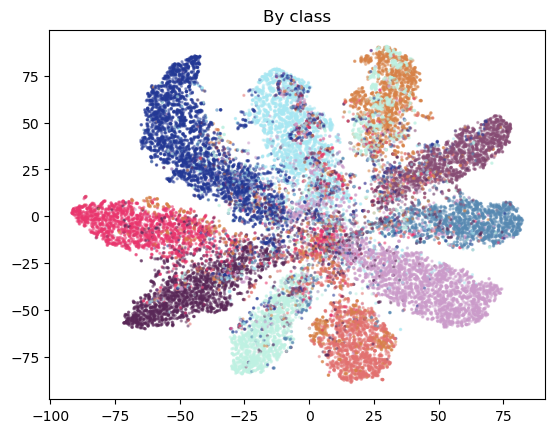

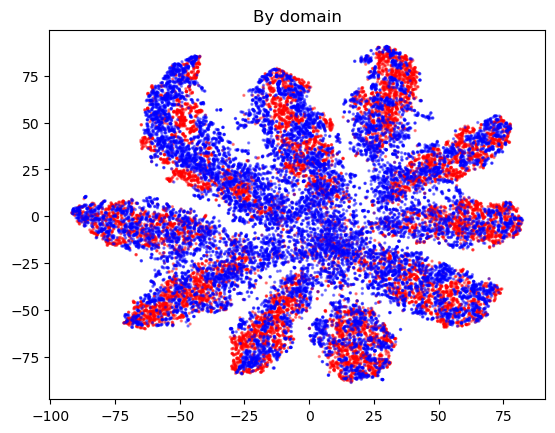

In [54]:
model = DANN_SVHM()
model.tsne()